In [3]:
from google.colab import drive
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
import tensorflow as tf
import cv2
import matplotlib.cm as cm
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from matplotlib import cm
from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import files

In [4]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ClevaSkin/ClevaDS.zip'
extract_path = '/content/ClevaDS'

# Ekstrak ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['ClevaDS']

In [5]:
# Path ke folder utama
base_path = '/content/ClevaDS/ClevaDS'

# List untuk menyimpan hasil
data = []

# Loop tiap folder (kelas)
for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        data.append({'Kelas': folder_name, 'Jumlah Gambar': count})

# Ubah jadi DataFrame
df = pd.DataFrame(data)
print(df)

                        Kelas  Jumlah Gambar
0                        Acne           1833
1                Athlete Foot           8054
2           Atopic Dermatitis           7645
3                  Cellulitis           8079
4                  Chickenpox           8083
5     Cutaneous Larva Migrans           8123
6   Disorders Of Pigmentation           7546
7                      Eczema           6715
8                    Impetigo           8148
9                 Nail Fungus           8083
10                   Non-Skin           6469
11                Normal Skin           7758
12                   Ringworm           8129
13                   Shingles           8082
14                    Unknown           1500
15            Urticaria Hives           7989


In [6]:
# Path ke folder utama
base_path = '/content/ClevaDS/ClevaDS'

# List penampung data
file_name = []
labels = []
full_path = []

# Looping untuk membaca semua gambar dan label
for path, subdirs, files in os.walk(base_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

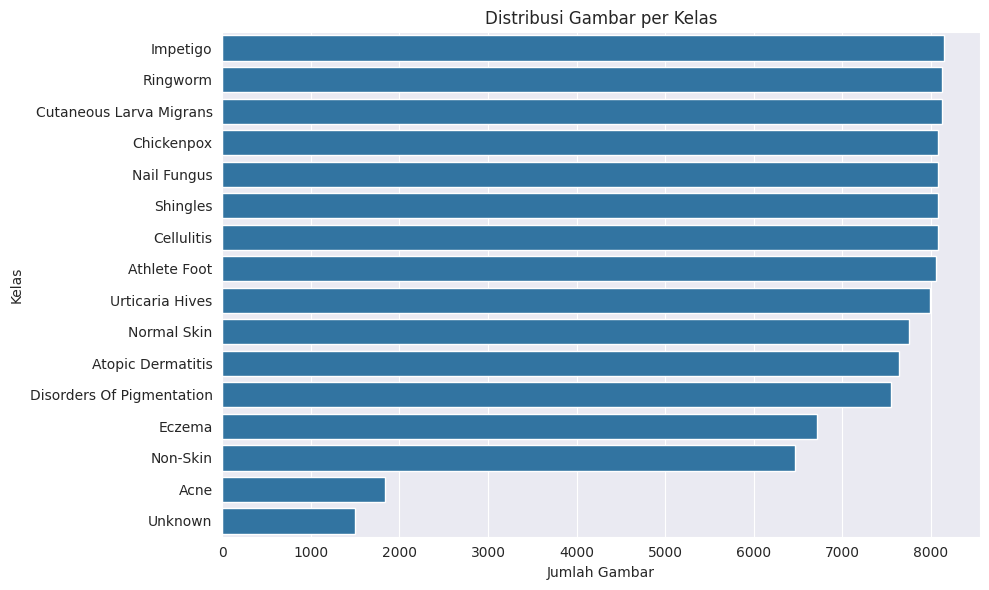

In [7]:
# Plot distribusi gambar per kelas
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, y='labels', order=distribution_train['labels'].value_counts().index)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas")
plt.tight_layout()
plt.show()

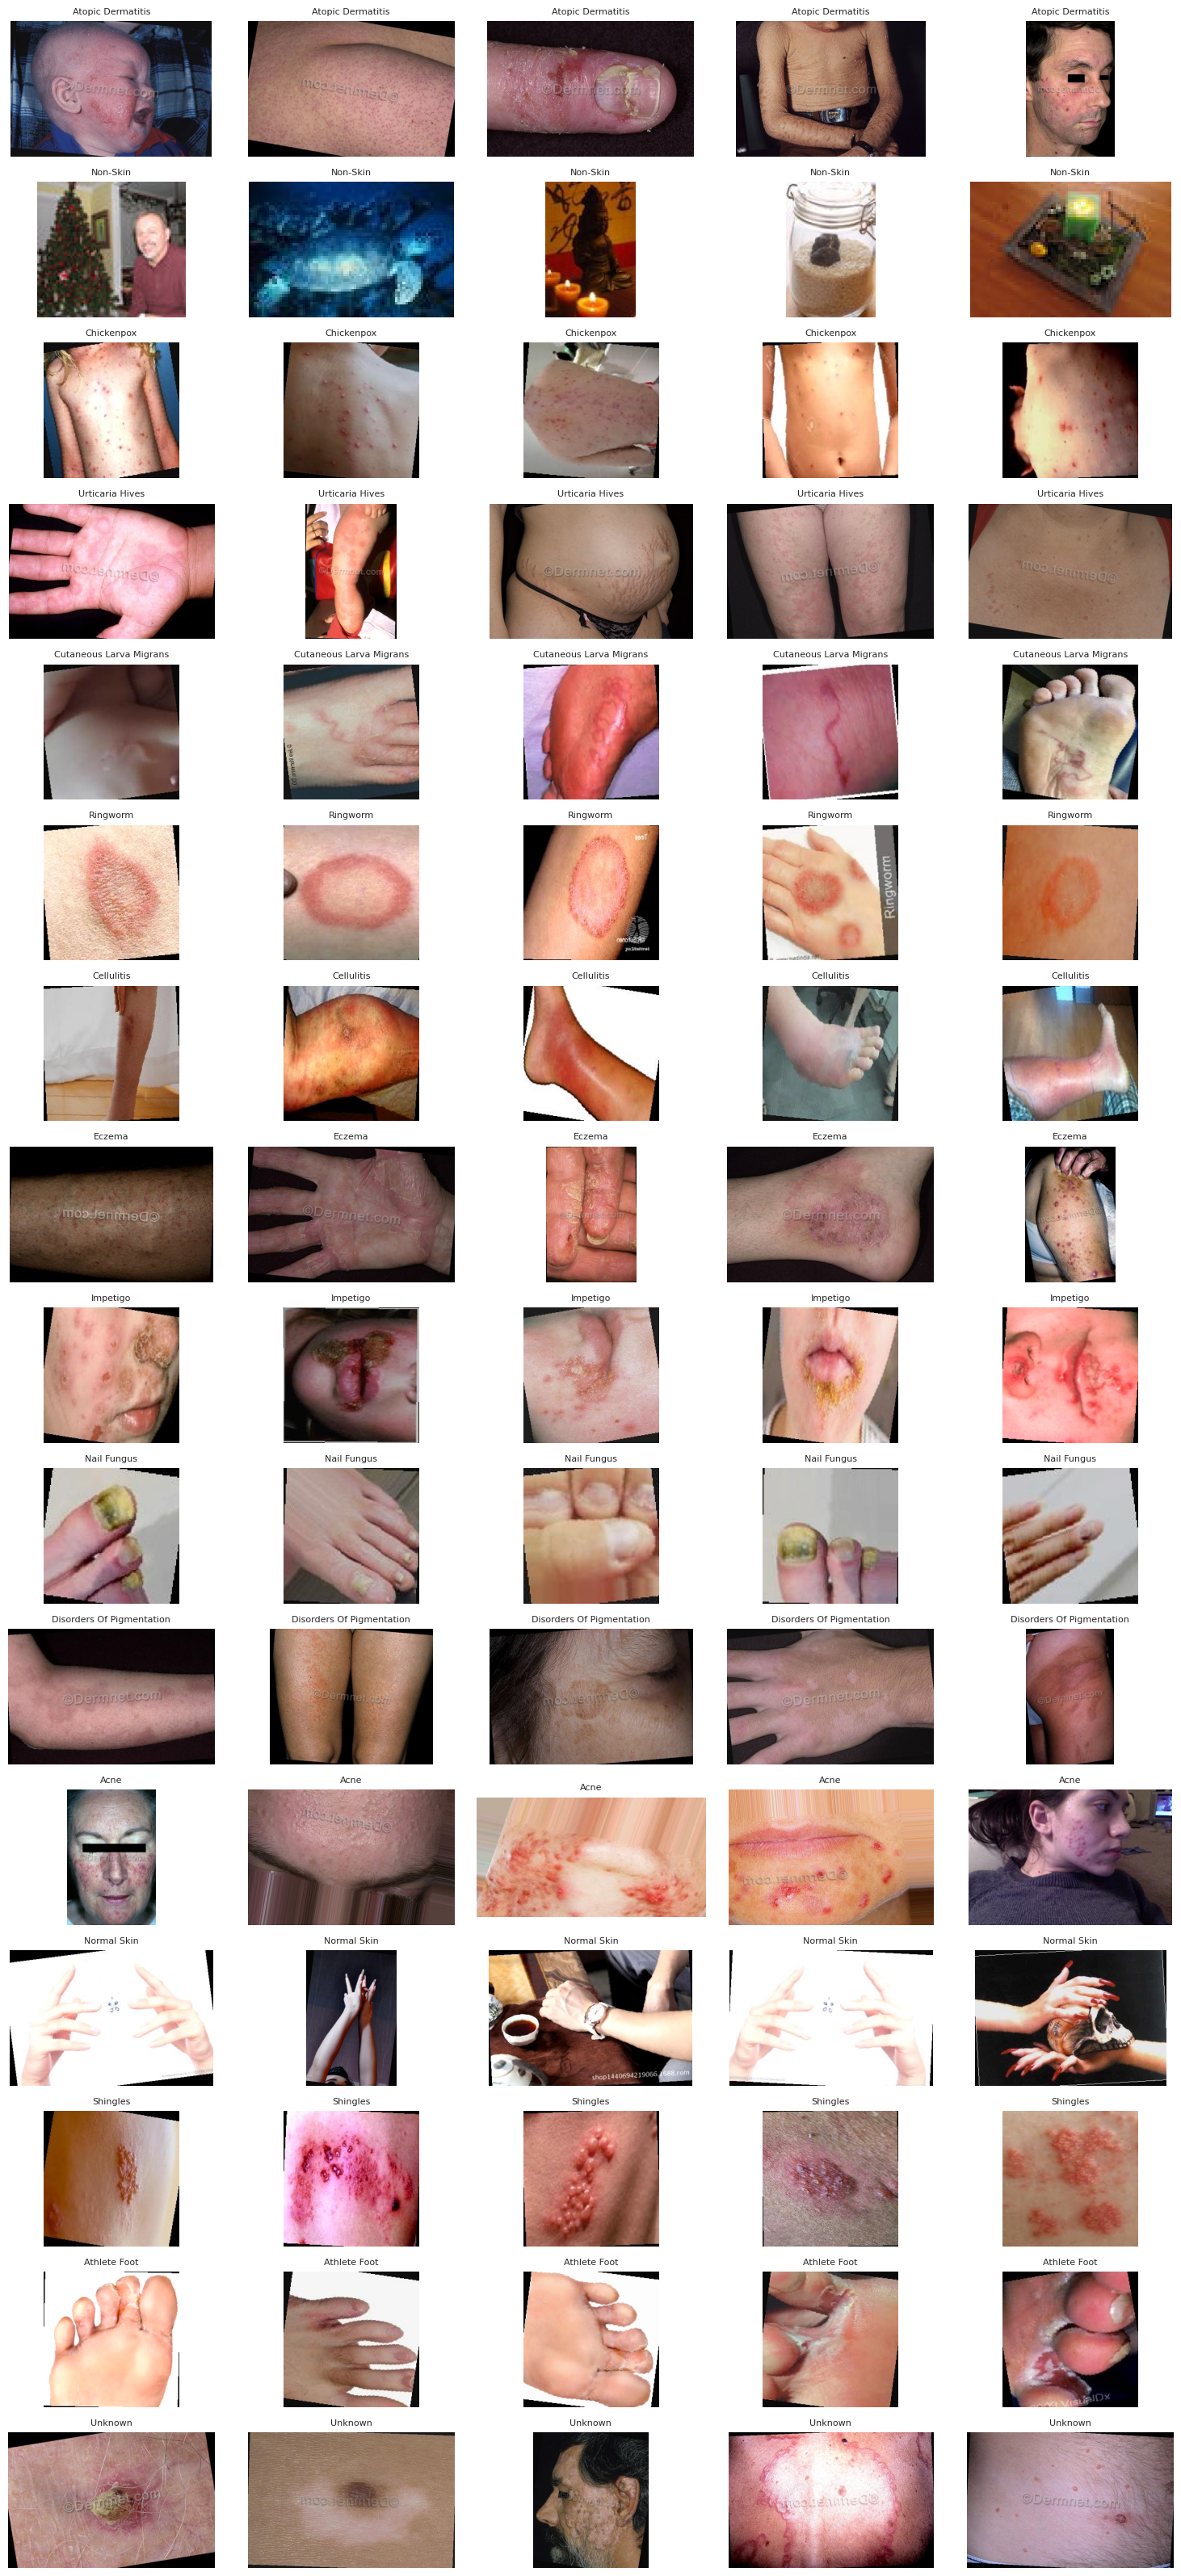

In [8]:
# Path ke dataset
dataset_path = '/content/ClevaDS/ClevaDS'

# Membuat kamus gambar untuk setiap kelas
disease_images = {}

# Mengisi kamus dengan nama file dari setiap kelas
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        disease_images[class_folder] = os.listdir(class_path)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(disease_images), 5, figsize=(15, len(disease_images) * 2))

for i, (class_name, image_list) in enumerate(disease_images.items()):
    selected_images = np.random.choice(image_list, 5, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Path sumber dan tujuan
source_path = base_path  # Folder asal semua kelas
target_path = '/content/balanced_dataset'
target_count = 1500  # Target per kelas

# Proses setiap kelas
for class_name in os.listdir(source_path):
    src_folder = os.path.join(source_path, class_name)
    dst_folder = os.path.join(target_path, class_name)
    os.makedirs(dst_folder, exist_ok=True)

    img_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(img_files)

    if current_count < target_count:
        print(f"❌ {class_name}: hanya {current_count} gambar, tidak cukup untuk undersampling.")
        continue

    print(f"Undersampling {class_name}: {current_count} → {target_count}")
    selected_files = random.sample(img_files, target_count)
    for img_name in selected_files:
        shutil.copy(os.path.join(src_folder, img_name), dst_folder)

Undersampling Atopic Dermatitis: 7645 → 1500
Undersampling Non-Skin: 6469 → 1500
Undersampling Chickenpox: 8083 → 1500
Undersampling Urticaria Hives: 7989 → 1500
Undersampling Cutaneous Larva Migrans: 8123 → 1500
Undersampling Ringworm: 8129 → 1500
Undersampling Cellulitis: 8079 → 1500
Undersampling Eczema: 6715 → 1500
Undersampling Impetigo: 8148 → 1500
Undersampling Nail Fungus: 8083 → 1500
Undersampling Disorders Of Pigmentation: 7546 → 1500
Undersampling Acne: 1832 → 1500
Undersampling Normal Skin: 7758 → 1500
Undersampling Shingles: 8082 → 1500
Undersampling Athlete Foot: 8054 → 1500
Undersampling Unknown: 1500 → 1500


In [10]:
balanced_path = '/content/balanced_dataset'

data = []

for class_name in sorted(os.listdir(balanced_path)):
    class_folder = os.path.join(balanced_path, class_name)
    if os.path.isdir(class_folder):
        count = len([
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        data.append({"Kelas": class_name, "Jumlah Gambar": count})

df_check = pd.DataFrame(data)
print(df_check)

                        Kelas  Jumlah Gambar
0                        Acne           1500
1                Athlete Foot           1500
2           Atopic Dermatitis           1500
3                  Cellulitis           1500
4                  Chickenpox           1500
5     Cutaneous Larva Migrans           1500
6   Disorders Of Pigmentation           1500
7                      Eczema           1500
8                    Impetigo           1500
9                 Nail Fungus           1500
10                   Non-Skin           1500
11                Normal Skin           1500
12                   Ringworm           1500
13                   Shingles           1500
14                    Unknown           1500
15            Urticaria Hives           1500


/tmp/ipython-input-2433308936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


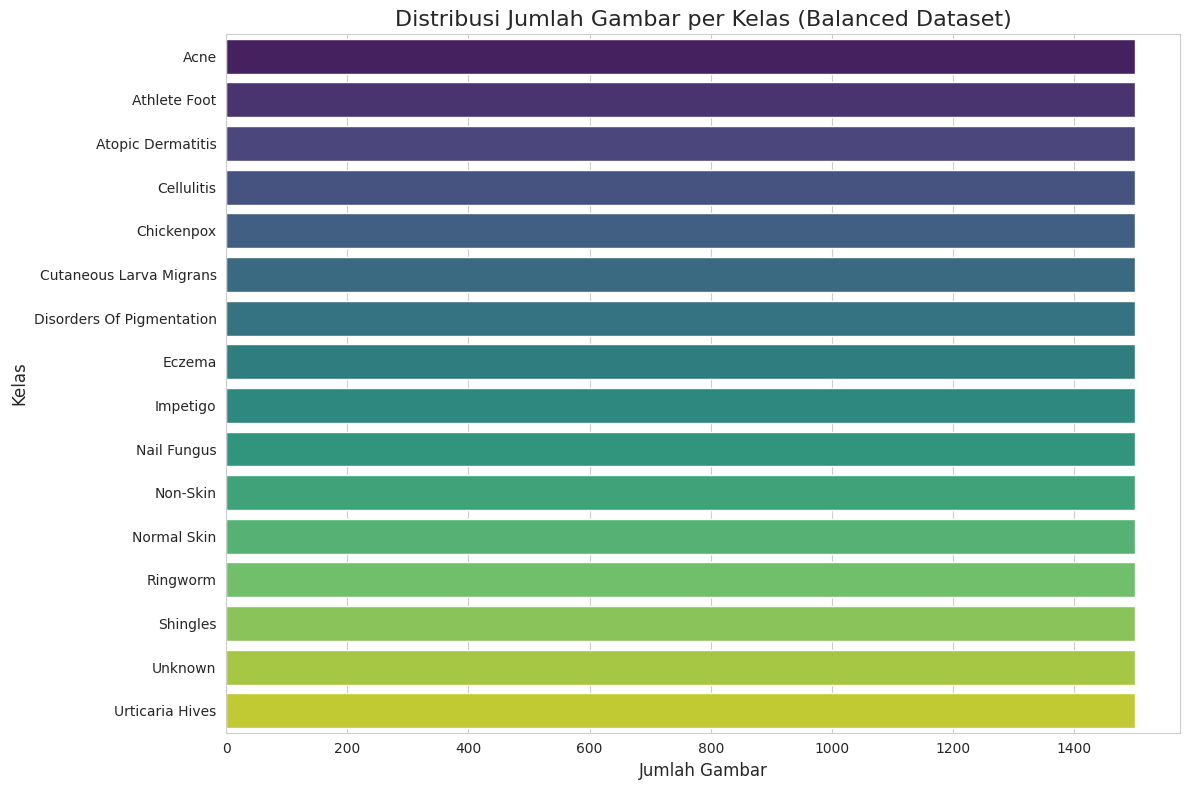

In [11]:
# Urutan kelas
df_check_sorted = df_check.sort_values(by="Jumlah Gambar", ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
plot = sns.barplot(
    data=df_check_sorted,
    x="Jumlah Gambar",
    y="Kelas",
    palette="viridis"
)

# Judul dan label
plt.title("Distribusi Jumlah Gambar per Kelas (Balanced Dataset)", fontsize=16)
plt.xlabel("Jumlah Gambar", fontsize=12)
plt.ylabel("Kelas", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
source_dir = '/content/balanced_dataset'
output_dir = '/content/split_dataset'
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Pastikan folder tujuan dibuat
for split in split_ratios.keys():
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Lakukan pemisahan untuk setiap kelas
for class_name in os.listdir(source_dir):
    img_dir = os.path.join(source_dir, class_name)
    images = os.listdir(img_dir)

    # Split: train → val → test
    train_files, testval_files = train_test_split(images, test_size=(1 - split_ratios['train']), random_state=42)
    val_files, test_files = train_test_split(testval_files, test_size=(split_ratios['test'] / (split_ratios['val'] + split_ratios['test'])), random_state=42)

    for fname in train_files:
        shutil.copy(os.path.join(img_dir, fname), os.path.join(output_dir, 'train', class_name))
    for fname in val_files:
        shutil.copy(os.path.join(img_dir, fname), os.path.join(output_dir, 'val', class_name))
    for fname in test_files:
        shutil.copy(os.path.join(img_dir, fname), os.path.join(output_dir, 'test', class_name))

print("Dataset berhasil di-split ke train/val/test.")

Dataset berhasil di-split ke train/val/test.


In [13]:
split_counts = []

for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_dir, split)
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        count = len(os.listdir(class_path))
        split_counts.append({
            'Split': split,
            'Kelas': class_name,
            'Jumlah Gambar': count
        })

df_split = pd.DataFrame(split_counts)
print(df_split.pivot(index='Kelas', columns='Split', values='Jumlah Gambar'))

Split                      test  train  val
Kelas                                      
Acne                        226   1049  225
Athlete Foot                226   1049  225
Atopic Dermatitis           226   1049  225
Cellulitis                  226   1049  225
Chickenpox                  226   1049  225
Cutaneous Larva Migrans     226   1049  225
Disorders Of Pigmentation   226   1049  225
Eczema                      226   1049  225
Impetigo                    226   1049  225
Nail Fungus                 226   1049  225
Non-Skin                    226   1049  225
Normal Skin                 226   1049  225
Ringworm                    226   1049  225
Shingles                    226   1049  225
Unknown                     226   1049  225
Urticaria Hives             226   1049  225


In [14]:
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # untuk evaluasi & confusion matrix
)

Found 16784 images belonging to 16 classes.
Found 3600 images belonging to 16 classes.
Found 3616 images belonging to 16 classes.


In [24]:
class_labels = [label for label, _ in sorted(train_data.class_indices.items(), key=lambda x: x[1])]
with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

print("class_labels.json berhasil disimpan.")
print("Urutan label:", class_labels)

class_labels.json berhasil disimpan.
Urutan label: ['Acne', 'Athlete Foot', 'Atopic Dermatitis', 'Cellulitis', 'Chickenpox', 'Cutaneous Larva Migrans', 'Disorders Of Pigmentation', 'Eczema', 'Impetigo', 'Nail Fungus', 'Non-Skin', 'Normal Skin', 'Ringworm', 'Shingles', 'Unknown', 'Urticaria Hives']


In [16]:
# Ambil jumlah kelas dari data generator
num_classes = train_data.num_classes  # otomatis dari folder

# Bangun model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,424,016 (9.25 MB)

 Trainable params: 166,032 (648.56 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Model dengan base MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan layer pre-trained

# Head klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Latih model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

# Evaluasi model
test_loss, test_acc = model.evaluate(test_data)
print(f"Akurasi data uji: {test_acc:.4f}")

# Simpan model
model.save('/content/skin_disease_model.h5')

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 122ms/step - accuracy: 0.1971 - loss: 2.6699 - val_accuracy: 0.6400 - val_loss: 1.2865
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.5849 - loss: 1.3224 - val_accuracy: 0.7222 - val_loss: 0.9358
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.6774 - loss: 0.9950 - val_accuracy: 0.7564 - val_loss: 0.7905
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7207 - loss: 0.8530 - val_accuracy: 0.7781 - val_loss: 0.7055
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7436 - loss: 0.7706 - val_accuracy: 0.7925 - val_loss: 0.6520
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.7682 - loss: 0.6959 - val_accuracy: 0.8028 - val_loss: 0.6098
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.7901 - loss: 0.6360 - val_accuracy: 0.8122 - val_loss: 0.5785
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7982 - loss: 0.6071 -

Akurasi data uji: 0.8576


In [18]:
# UNFREEZE base model
base_model.trainable = True

# Compile ulang dengan learning rate lebih kecil
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback
earlystop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.2, verbose=1)
checkpoint_finetune = ModelCheckpoint(
    'best_model_finetuned.h5', monitor='val_accuracy', mode='max',
    save_best_only=True, verbose=1
)

# Fine-tune
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[earlystop, reduce_lr, checkpoint_finetune]
)

# Evaluasi akhir
final_loss, final_acc = model.evaluate(test_data)
print(f"Akurasi data uji setelah fine-tuning: {final_acc:.4f}")

# Simpan model final
model.save('/conte nt/skin_disease_model_finetuned.h5')

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4817 - loss: 2.1428
Epoch 1: val_accuracy improved from -inf to 0.79167, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 150s 188ms/step - accuracy: 0.4820 - loss: 2.1412 - val_accuracy: 0.7917 - val_loss: 0.5761 - learning_rate: 1.0000e-05
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7922 - loss: 0.6079
Epoch 2: val_accuracy improved from 0.79167 to 0.81500, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - accuracy: 0.7922 - loss: 0.6078 - val_accuracy: 0.8150 - val_loss: 0.5025 - learning_rate: 1.0000e-05
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8395 - loss: 0.4660
Epoch 3: val_accuracy improved from 0.81500 to 0.84694, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.8395 - loss: 0.4660 - val_accuracy: 0.8469 - val_loss: 0.4239 - learning_rate: 1.0000e-05
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8596 - loss: 0.3912
Epoch 4: val_accuracy improved from 0.84694 to 0.86833, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - accuracy: 0.8596 - loss: 0.3912 - val_accuracy: 0.8683 - val_loss: 0.3686 - learning_rate: 1.0000e-05
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8774 - loss: 0.3447
Epoch 5: val_accuracy improved from 0.86833 to 0.87694, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - accuracy: 0.8774 - loss: 0.3447 - val_accuracy: 0.8769 - val_loss: 0.3401 - learning_rate: 1.0000e-05
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9018 - loss: 0.2860
Epoch 6: val_accuracy improved from 0.87694 to 0.88778, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.9018 - loss: 0.2860 - val_accuracy: 0.8878 - val_loss: 0.3093 - learning_rate: 1.0000e-05
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9115 - loss: 0.2603
Epoch 7: val_accuracy improved from 0.88778 to 0.89722, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - accuracy: 0.9115 - loss: 0.2603 - val_accuracy: 0.8972 - val_loss: 0.2840 - learning_rate: 1.0000e-05
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9228 - loss: 0.2221
Epoch 8: val_accuracy improved from 0.89722 to 0.89917, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 122ms/step - accuracy: 0.9228 - loss: 0.2221 - val_accuracy: 0.8992 - val_loss: 0.2741 - learning_rate: 1.0000e-05
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9343 - loss: 0.1911
Epoch 9: val_accuracy improved from 0.89917 to 0.90806, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.9343 - loss: 0.1912 - val_accuracy: 0.9081 - val_loss: 0.2561 - learning_rate: 1.0000e-05
Epoch 10/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9463 - loss: 0.1654
Epoch 10: val_accuracy improved from 0.90806 to 0.91389, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 66s 125ms/step - accuracy: 0.9463 - loss: 0.1654 - val_accuracy: 0.9139 - val_loss: 0.2462 - learning_rate: 1.0000e-05
Epoch 11/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9539 - loss: 0.1459
Epoch 11: val_accuracy improved from 0.91389 to 0.91639, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 122ms/step - accuracy: 0.9539 - loss: 0.1459 - val_accuracy: 0.9164 - val_loss: 0.2410 - learning_rate: 1.0000e-05
Epoch 12/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9617 - loss: 0.1253
Epoch 12: val_accuracy improved from 0.91639 to 0.91694, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 66s 125ms/step - accuracy: 0.9617 - loss: 0.1253 - val_accuracy: 0.9169 - val_loss: 0.2422 - learning_rate: 1.0000e-05
Epoch 13/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9669 - loss: 0.1108
Epoch 13: val_accuracy improved from 0.91694 to 0.92361, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 121ms/step - accuracy: 0.9669 - loss: 0.1108 - val_accuracy: 0.9236 - val_loss: 0.2315 - learning_rate: 1.0000e-05
Epoch 14/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9702 - loss: 0.0967
Epoch 14: val_accuracy improved from 0.92361 to 0.92528, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.9702 - loss: 0.0967 - val_accuracy: 0.9253 - val_loss: 0.2270 - learning_rate: 1.0000e-05
Epoch 15/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9753 - loss: 0.0813
Epoch 15: val_accuracy did not improve from 0.92528
525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 121ms/step - accuracy: 0.9753 - loss: 0.0813 - val_accuracy: 0.9247 - val_loss: 0.2371 - learning_rate: 1.0000e-05
Epoch 16/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9818 - loss: 0.0667
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 16: val_accuracy improved from 0.92528 to 0.92611, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.9818 - loss: 0.0667 - val_accuracy: 0.9261 - val_loss: 0.2338 - learning_rate: 1.0000e-05
Epoch 17/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9847 - loss: 0.0579
Epoch 17: val_accuracy improved from 0.92611 to 0.92889, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - accuracy: 0.9847 - loss: 0.0579 - val_accuracy: 0.9289 - val_loss: 0.2254 - learning_rate: 2.0000e-06
Epoch 18/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9831 - loss: 0.0573
Epoch 18: val_accuracy improved from 0.92889 to 0.92917, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - accuracy: 0.9831 - loss: 0.0573 - val_accuracy: 0.9292 - val_loss: 0.2254 - learning_rate: 2.0000e-06
Epoch 19/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9874 - loss: 0.0480
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.

Epoch 19: val_accuracy improved from 0.92917 to 0.93000, saving model to best_model_finetuned.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 121ms/step - accuracy: 0.9874 - loss: 0.0481 - val_accuracy: 0.9300 - val_loss: 0.2253 - learning_rate: 2.0000e-06
Epoch 20/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9861 - loss: 0.0537
Epoch 20: val_accuracy did not improve from 0.93000
525/525 ━━━━━━━━━━━━━━━━━━━━ 62s 118ms/step - accuracy: 0.9861 - loss: 0.0537 - val_accuracy: 0.9292 - val_loss: 0.2261 - learning_rate: 4.0000e-07
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9418 - loss: 0.1993


Akurasi data uji setelah fine-tuning: 0.9356


Found 24000 images belonging to 16 classes.
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step
Classification Report:
                           precision    recall  f1-score   support

                     Acne       0.98      0.98      0.98      1500
             Athlete Foot       1.00      1.00      1.00      1500
        Atopic Dermatitis       0.94      0.95      0.94      1500
               Cellulitis       1.00      1.00      1.00      1500
               Chickenpox       1.00      1.00      1.00      1500
  Cutaneous Larva Migrans       1.00      1.00      1.00      1500
Disorders Of Pigmentation       0.93      0.94      0.93      1500
                   Eczema       0.94      0.92      0.93      1500
                 Impetigo       1.00      1.00      1.00      1500
              Nail Fungus       1.00      1.00      1.00      1500
                 Non-Skin       1.00      1.00      1.00      1500
              Normal Skin       1.00      1.00      1.00      1500
                 R

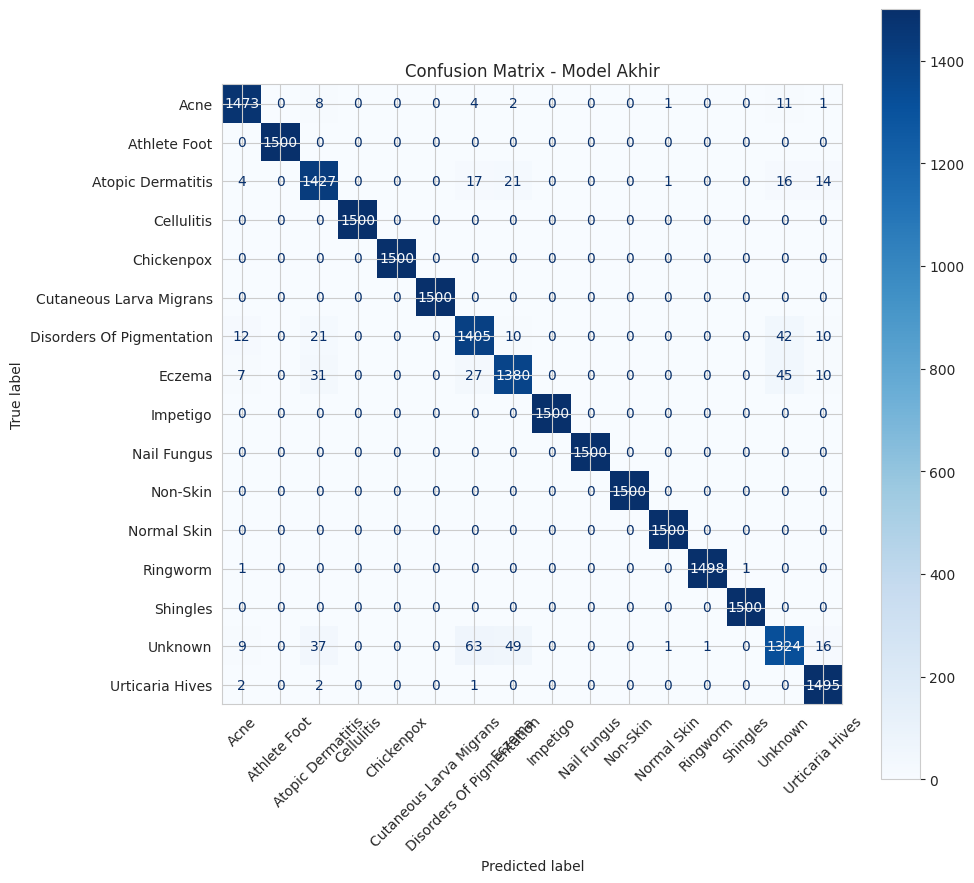

In [19]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    '/content/balanced_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Prediksi
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Model Akhir")
plt.show()

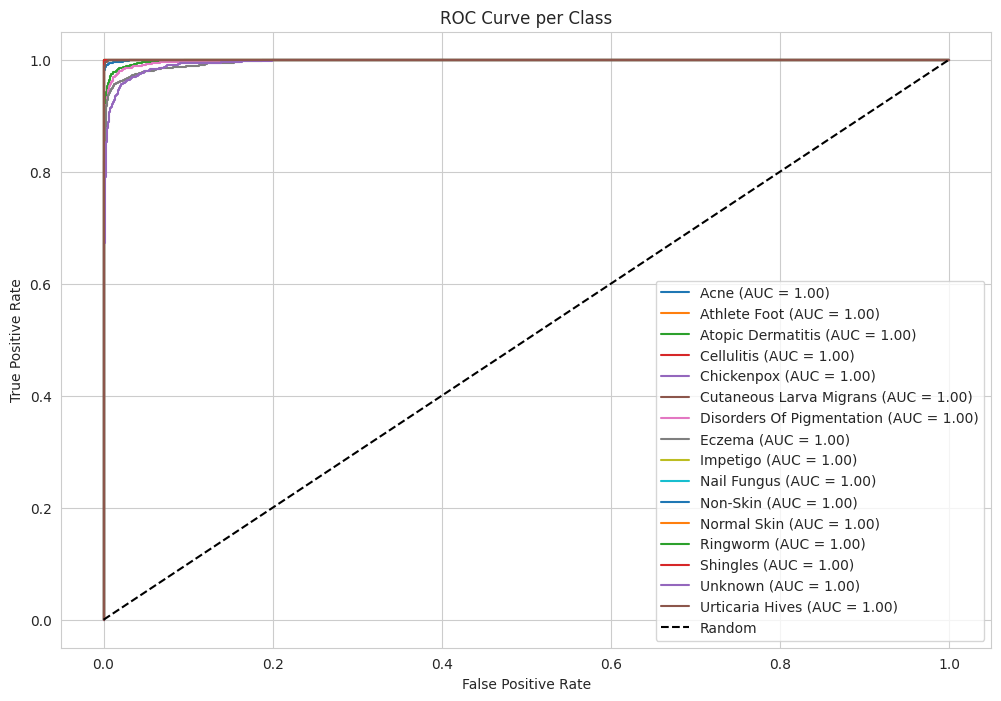

In [20]:
# ROC CURVE per kelas
# Binarize label untuk ROC
y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC per kelas
plt.figure(figsize=(12, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

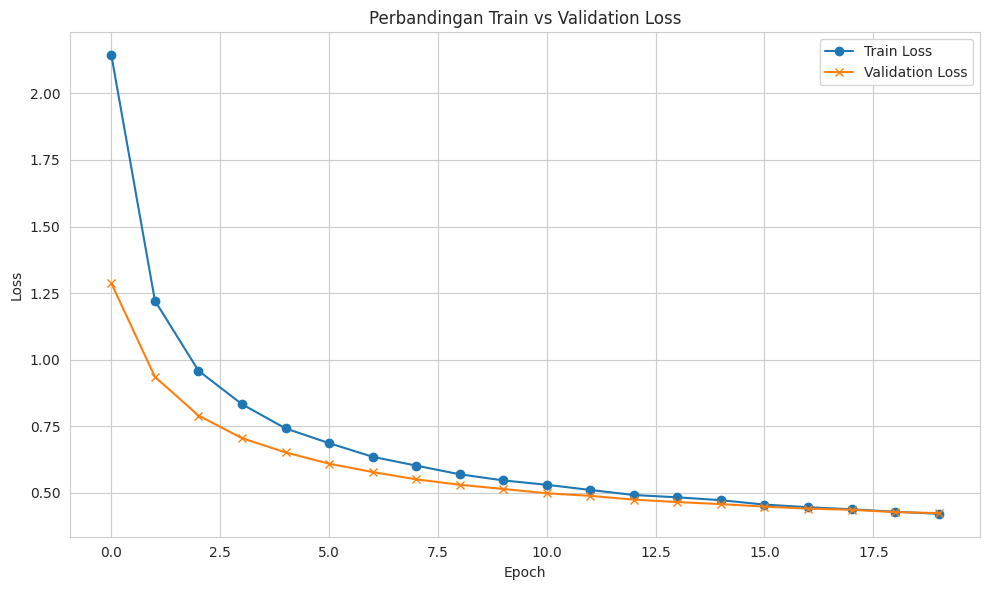

In [21]:
# Perbandingan Train vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Perbandingan Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

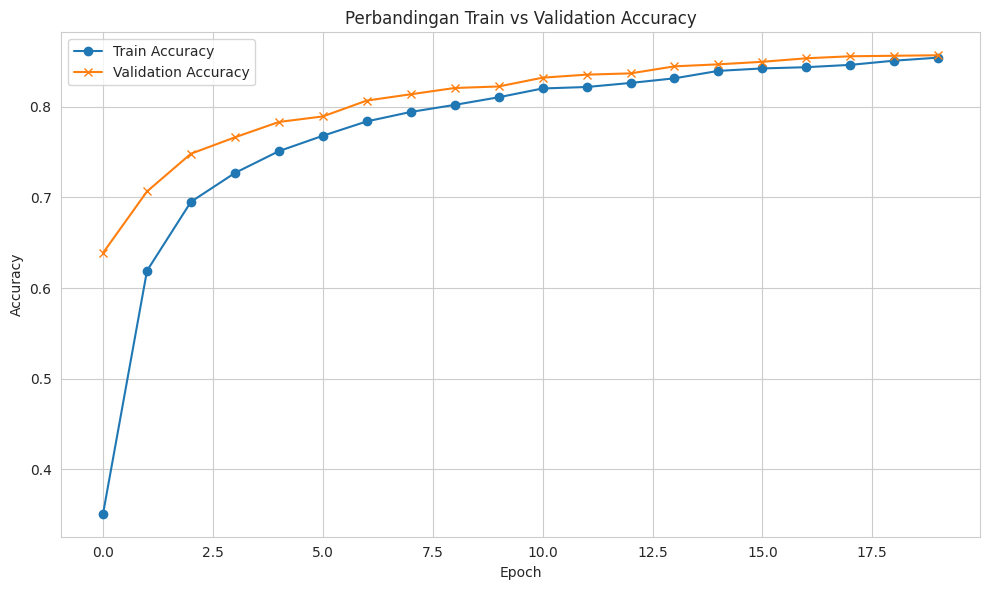

In [ ]:
# Perbandingan Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Perbandingan Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Saving 1236.jpg to 1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Prediksi Awal: Ringworm (94.99%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Hasil Prediksi Akhir:
Ringworm                 : 94.99%
Unknown                  : 3.45%
Urticaria Hives          : 1.55%
Eczema                   : 0.01%
Normal Skin              : 0.00%
Nail Fungus              : 0.00%
Disorders Of Pigmentation: 0.00%
Athlete Foot             : 0.00%
Cutaneous Larva Migrans  : 0.00%
Atopic Dermatitis        : 0.00%
Acne                     : 0.00%
Cellulitis               : 0.00%
Non-Skin                 : 0.00%
Shingles                 : 0.00%
Impetigo                 : 0.00%
Chickenpox               : 0.00%


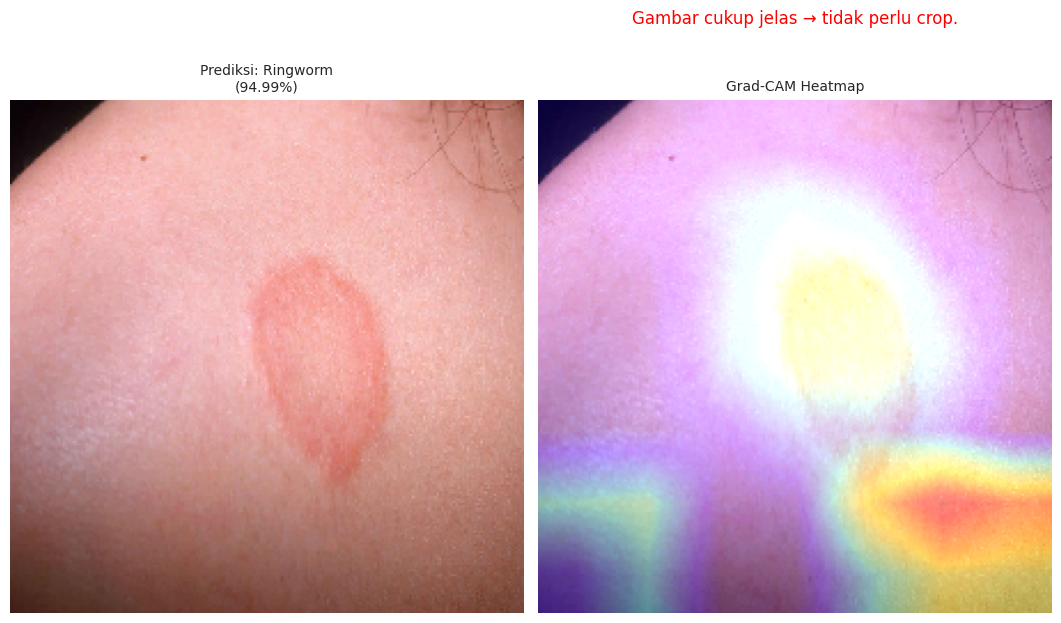

In [36]:
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load image
img = load_img(image_path, target_size=(224, 224))
img_np = img_to_array(img) / 255.0
x = np.expand_dims(img_np, axis=0)


# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prediksi Awal
pred_initial = model.predict(x)[0]
sorted_initial = sorted(zip(class_labels, pred_initial), key=lambda x: x[1], reverse=True)
initial_label, initial_conf = sorted_initial[0]
print(f"\nPrediksi Awal: {initial_label} ({initial_conf:.2%})")

# Grad-CAM
heatmap = make_gradcam_heatmap(x, model)
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_mask = (heatmap_resized > 0.4).astype("uint8")
prop_panas = np.sum(heatmap_mask) / (224 * 224)

# Adaptive Crop
if prop_panas < 0.3 and initial_conf < 0.60:
    contours, _ = cv2.findContours(heatmap_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x_min, y_min, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped_img = img_np[y_min:y_min+h, x_min:x_min+w]
        cropped_img_resized = cv2.resize(cropped_img, (224, 224))
        cropped_input = np.expand_dims(cropped_img_resized, axis=0)
        crop_note = "Area kecil & confidence rendah → dilakukan crop."
    else:
        cropped_img_resized = img_np
        cropped_input = x
        crop_note = "Tidak ada kontur signifikan → gambar asli dipakai."
else:
    cropped_img_resized = img_np
    cropped_input = x
    crop_note = "Gambar cukup jelas → tidak perlu crop."

# Prediksi Akhir
pred = model.predict(cropped_input)[0]
sorted_pred = sorted(zip(class_labels, pred), key=lambda x: x[1], reverse=True)
pred_label, confidence = sorted_pred[0]

# Interpretasi
normal_conf = dict(sorted_pred).get("Normal Skin", 0)
nonskin_conf = dict(sorted_pred).get("Non-Skin", 0)
unknown_conf = dict(sorted_pred).get("Unknown", 0)

hybrid_alert = ""
if confidence < 0.60:
    pred_label = "Tidak dikenali"
    hybrid_alert = "Model tidak yakin. Gambar bisa blur, noise, atau belum dikenali."
elif pred_label == "Non-Skin":
    hybrid_alert = "Gambar terdeteksi sebagai Non-Skin (bukan kulit manusia)."
elif pred_label == "Unknown":
    hybrid_alert = "Gambar terdeteksi sebagai penyakit kulit lain (di luar 13 kelas utama)."
elif pred_label == "Normal Skin" and dict(sorted_pred).get("Acne", 0) >= 0.05:
    hybrid_alert = f"Kulit tampak normal, tapi ada indikasi ringan dari acne ({dict(sorted_pred)['Acne']:.2%})"

# Cetak Prediksi
print("\nHasil Prediksi Akhir:")
for label, score in sorted_pred:
    print(f"{label:25}: {score*100:.2f}%")

# Visualisasi
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(cropped_img_resized)
plt.title(f"Prediksi: {pred_label}\n({confidence:.2%})", fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 2)
heatmap_color = cm.jet(heatmap_resized)[..., :3]
superimposed_img = np.clip(heatmap_color * 0.4 + img_np, 0, 1)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap", fontsize=10)
plt.axis('off')

plt.suptitle(hybrid_alert if hybrid_alert else crop_note, fontsize=12, y=1.05, color='red')
plt.tight_layout()
plt.show()

Saving Filliform-warts.jpg to Filliform-warts.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Prediksi Awal: Unknown (99.05%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Hasil Prediksi Akhir:
Unknown                  : 99.05%
Eczema                   : 0.51%
Acne                     : 0.21%
Disorders Of Pigmentation: 0.17%
Ringworm                 : 0.06%
Non-Skin                 : 0.00%
Nail Fungus              : 0.00%
Normal Skin              : 0.00%
Shingles                 : 0.00%
Atopic Dermatitis        : 0.00%
Impetigo                 : 0.00%
Cutaneous Larva Migrans  : 0.00%
Athlete Foot             : 0.00%
Urticaria Hives          : 0.00%
Cellulitis               : 0.00%
Chickenpox               : 0.00%


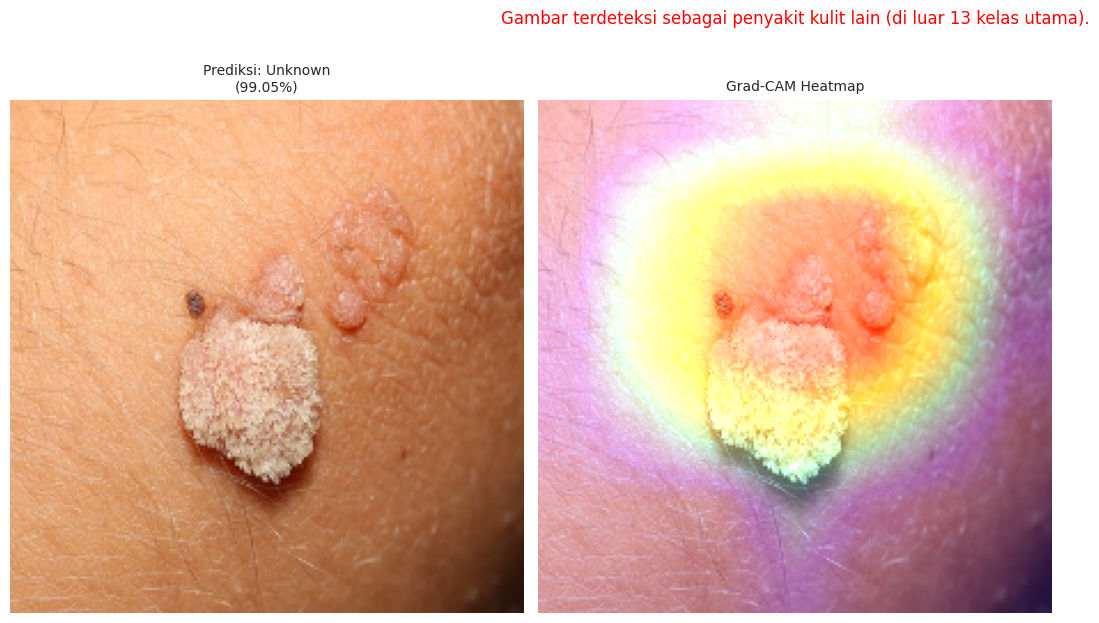

In [42]:
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load image
img = load_img(image_path, target_size=(224, 224))
img_np = img_to_array(img) / 255.0
x = np.expand_dims(img_np, axis=0)


# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prediksi Awal
pred_initial = model.predict(x)[0]
sorted_initial = sorted(zip(class_labels, pred_initial), key=lambda x: x[1], reverse=True)
initial_label, initial_conf = sorted_initial[0]
print(f"\nPrediksi Awal: {initial_label} ({initial_conf:.2%})")

# Grad-CAM
heatmap = make_gradcam_heatmap(x, model)
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_mask = (heatmap_resized > 0.4).astype("uint8")
prop_panas = np.sum(heatmap_mask) / (224 * 224)

# Adaptive Crop
if prop_panas < 0.3 and initial_conf < 0.60:
    contours, _ = cv2.findContours(heatmap_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x_min, y_min, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped_img = img_np[y_min:y_min+h, x_min:x_min+w]
        cropped_img_resized = cv2.resize(cropped_img, (224, 224))
        cropped_input = np.expand_dims(cropped_img_resized, axis=0)
        crop_note = "Area kecil & confidence rendah → dilakukan crop."
    else:
        cropped_img_resized = img_np
        cropped_input = x
        crop_note = "Tidak ada kontur signifikan → gambar asli dipakai."
else:
    cropped_img_resized = img_np
    cropped_input = x
    crop_note = "Gambar cukup jelas → tidak perlu crop."

# Prediksi Akhir
pred = model.predict(cropped_input)[0]
sorted_pred = sorted(zip(class_labels, pred), key=lambda x: x[1], reverse=True)
pred_label, confidence = sorted_pred[0]

# Interpretasi
normal_conf = dict(sorted_pred).get("Normal Skin", 0)
nonskin_conf = dict(sorted_pred).get("Non-Skin", 0)
unknown_conf = dict(sorted_pred).get("Unknown", 0)

hybrid_alert = ""
if confidence < 0.60:
    pred_label = "Tidak dikenali"
    hybrid_alert = "Model tidak yakin. Gambar bisa blur, noise, atau belum dikenali."
elif pred_label == "Non-Skin":
    hybrid_alert = "Gambar terdeteksi sebagai Non-Skin (bukan kulit manusia)."
elif pred_label == "Unknown":
    hybrid_alert = "Gambar terdeteksi sebagai penyakit kulit lain (di luar 13 kelas utama)."
elif pred_label == "Normal Skin" and dict(sorted_pred).get("Acne", 0) >= 0.05:
    hybrid_alert = f"Kulit tampak normal, tapi ada indikasi ringan dari acne ({dict(sorted_pred)['Acne']:.2%})"

# Cetak Prediksi
print("\nHasil Prediksi Akhir:")
for label, score in sorted_pred:
    print(f"{label:25}: {score*100:.2f}%")

# Visualisasi
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(cropped_img_resized)
plt.title(f"Prediksi: {pred_label}\n({confidence:.2%})", fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 2)
heatmap_color = cm.jet(heatmap_resized)[..., :3]
superimposed_img = np.clip(heatmap_color * 0.4 + img_np, 0, 1)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap", fontsize=10)
plt.axis('off')

plt.suptitle(hybrid_alert if hybrid_alert else crop_note, fontsize=12, y=1.05, color='red')
plt.tight_layout()
plt.show()

Saving 749992e8739bc3eb1183990e14dbe05d.jpg to 749992e8739bc3eb1183990e14dbe05d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Prediksi Awal: Non-Skin (45.37%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Hasil Prediksi Akhir:
Non-Skin                 : 68.35%
Cellulitis               : 31.04%
Disorders Of Pigmentation: 0.28%
Normal Skin              : 0.13%
Acne                     : 0.07%
Ringworm                 : 0.07%
Unknown                  : 0.04%
Shingles                 : 0.02%
Atopic Dermatitis        : 0.01%
Impetigo                 : 0.00%
Chickenpox               : 0.00%
Athlete Foot             : 0.00%
Nail Fungus              : 0.00%
Eczema                   : 0.00%
Urticaria Hives          : 0.00%
Cutaneous Larva Migrans  : 0.00%


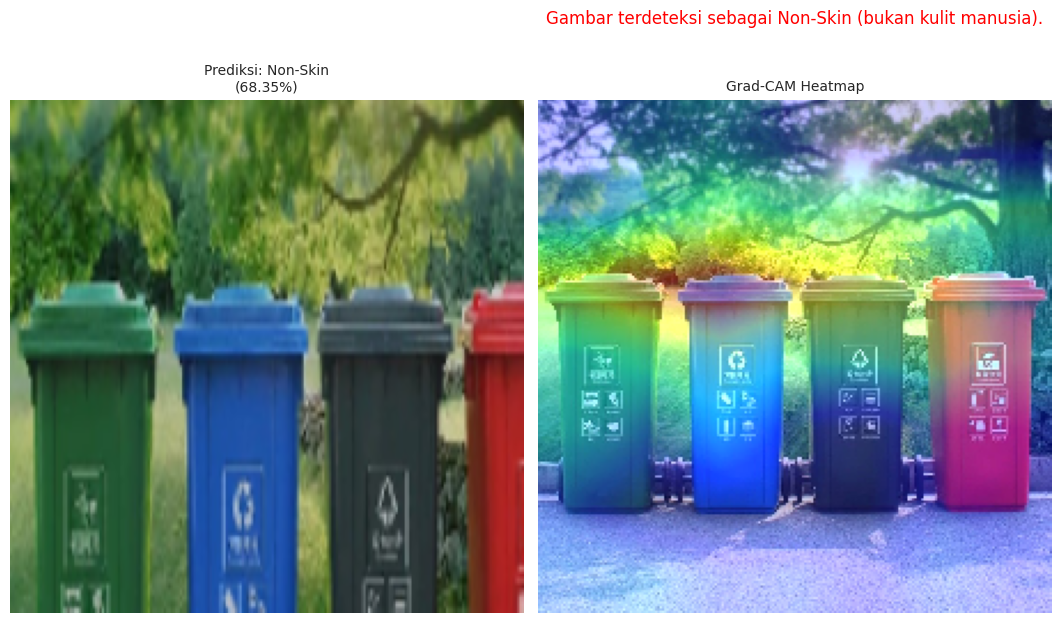

In [43]:
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load image
img = load_img(image_path, target_size=(224, 224))
img_np = img_to_array(img) / 255.0
x = np.expand_dims(img_np, axis=0)


# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prediksi Awal
pred_initial = model.predict(x)[0]
sorted_initial = sorted(zip(class_labels, pred_initial), key=lambda x: x[1], reverse=True)
initial_label, initial_conf = sorted_initial[0]
print(f"\nPrediksi Awal: {initial_label} ({initial_conf:.2%})")

# Grad-CAM
heatmap = make_gradcam_heatmap(x, model)
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_mask = (heatmap_resized > 0.4).astype("uint8")
prop_panas = np.sum(heatmap_mask) / (224 * 224)

# Adaptive Crop
if prop_panas < 0.3 and initial_conf < 0.60:
    contours, _ = cv2.findContours(heatmap_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x_min, y_min, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped_img = img_np[y_min:y_min+h, x_min:x_min+w]
        cropped_img_resized = cv2.resize(cropped_img, (224, 224))
        cropped_input = np.expand_dims(cropped_img_resized, axis=0)
        crop_note = "Area kecil & confidence rendah → dilakukan crop."
    else:
        cropped_img_resized = img_np
        cropped_input = x
        crop_note = "Tidak ada kontur signifikan → gambar asli dipakai."
else:
    cropped_img_resized = img_np
    cropped_input = x
    crop_note = "Gambar cukup jelas → tidak perlu crop."

# Prediksi Akhir
pred = model.predict(cropped_input)[0]
sorted_pred = sorted(zip(class_labels, pred), key=lambda x: x[1], reverse=True)
pred_label, confidence = sorted_pred[0]

# Interpretasi
normal_conf = dict(sorted_pred).get("Normal Skin", 0)
nonskin_conf = dict(sorted_pred).get("Non-Skin", 0)
unknown_conf = dict(sorted_pred).get("Unknown", 0)

hybrid_alert = ""
if confidence < 0.60:
    pred_label = "Tidak dikenali"
    hybrid_alert = "Model tidak yakin. Gambar bisa blur, noise, atau belum dikenali."
elif pred_label == "Non-Skin":
    hybrid_alert = "Gambar terdeteksi sebagai Non-Skin (bukan kulit manusia)."
elif pred_label == "Unknown":
    hybrid_alert = "Gambar terdeteksi sebagai penyakit kulit lain (di luar 13 kelas utama)."
elif pred_label == "Normal Skin" and dict(sorted_pred).get("Acne", 0) >= 0.05:
    hybrid_alert = f"Kulit tampak normal, tapi ada indikasi ringan dari acne ({dict(sorted_pred)['Acne']:.2%})"

# Cetak Prediksi
print("\nHasil Prediksi Akhir:")
for label, score in sorted_pred:
    print(f"{label:25}: {score*100:.2f}%")

# Visualisasi
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(cropped_img_resized)
plt.title(f"Prediksi: {pred_label}\n({confidence:.2%})", fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 2)
heatmap_color = cm.jet(heatmap_resized)[..., :3]
superimposed_img = np.clip(heatmap_color * 0.4 + img_np, 0, 1)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap", fontsize=10)
plt.axis('off')

plt.suptitle(hybrid_alert if hybrid_alert else crop_note, fontsize=12, y=1.05, color='red')
plt.tight_layout()
plt.show()

Saving beb4a8882f011b080a1c95b3a090a992.jpg to beb4a8882f011b080a1c95b3a090a992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Prediksi Awal: Normal Skin (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Hasil Prediksi Akhir:
Normal Skin              : 100.00%
Unknown                  : 0.00%
Disorders Of Pigmentation: 0.00%
Atopic Dermatitis        : 0.00%
Acne                     : 0.00%
Non-Skin                 : 0.00%
Urticaria Hives          : 0.00%
Eczema                   : 0.00%
Cellulitis               : 0.00%
Cutaneous Larva Migrans  : 0.00%
Athlete Foot             : 0.00%
Ringworm                 : 0.00%
Chickenpox               : 0.00%
Nail Fungus              : 0.00%
Shingles                 : 0.00%
Impetigo                 : 0.00%


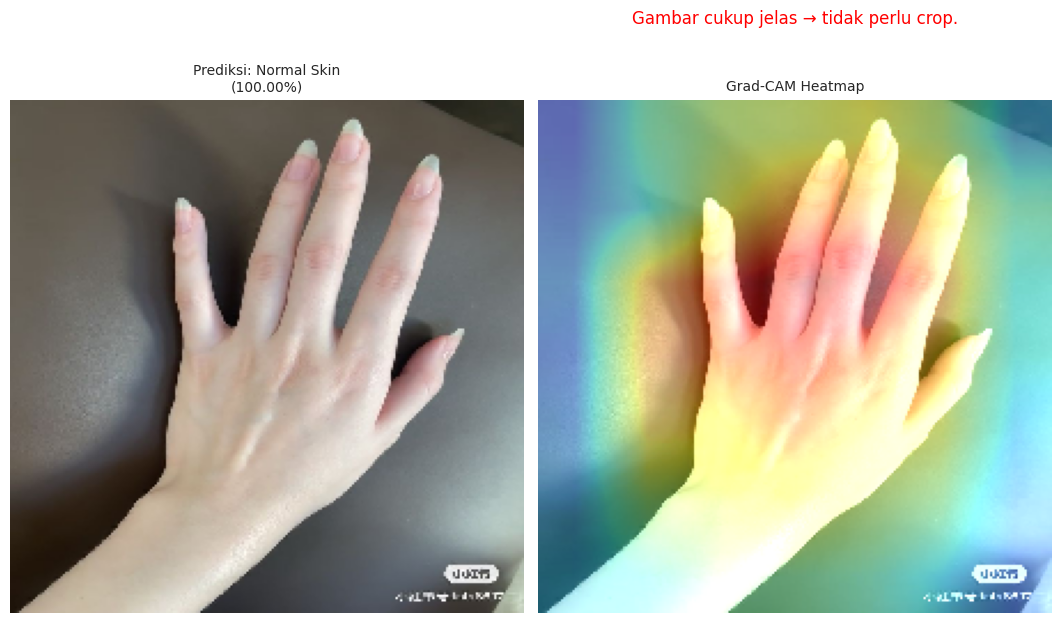

In [44]:
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load image
img = load_img(image_path, target_size=(224, 224))
img_np = img_to_array(img) / 255.0
x = np.expand_dims(img_np, axis=0)


# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prediksi Awal
pred_initial = model.predict(x)[0]
sorted_initial = sorted(zip(class_labels, pred_initial), key=lambda x: x[1], reverse=True)
initial_label, initial_conf = sorted_initial[0]
print(f"\nPrediksi Awal: {initial_label} ({initial_conf:.2%})")

# Grad-CAM
heatmap = make_gradcam_heatmap(x, model)
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_mask = (heatmap_resized > 0.4).astype("uint8")
prop_panas = np.sum(heatmap_mask) / (224 * 224)

# Adaptive Crop
if prop_panas < 0.3 and initial_conf < 0.60:
    contours, _ = cv2.findContours(heatmap_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x_min, y_min, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped_img = img_np[y_min:y_min+h, x_min:x_min+w]
        cropped_img_resized = cv2.resize(cropped_img, (224, 224))
        cropped_input = np.expand_dims(cropped_img_resized, axis=0)
        crop_note = "Area kecil & confidence rendah → dilakukan crop."
    else:
        cropped_img_resized = img_np
        cropped_input = x
        crop_note = "Tidak ada kontur signifikan → gambar asli dipakai."
else:
    cropped_img_resized = img_np
    cropped_input = x
    crop_note = "Gambar cukup jelas → tidak perlu crop."

# Prediksi Akhir
pred = model.predict(cropped_input)[0]
sorted_pred = sorted(zip(class_labels, pred), key=lambda x: x[1], reverse=True)
pred_label, confidence = sorted_pred[0]

# Interpretasi
normal_conf = dict(sorted_pred).get("Normal Skin", 0)
nonskin_conf = dict(sorted_pred).get("Non-Skin", 0)
unknown_conf = dict(sorted_pred).get("Unknown", 0)

hybrid_alert = ""
if confidence < 0.60:
    pred_label = "Tidak dikenali"
    hybrid_alert = "Model tidak yakin. Gambar bisa blur, noise, atau belum dikenali."
elif pred_label == "Non-Skin":
    hybrid_alert = "Gambar terdeteksi sebagai Non-Skin (bukan kulit manusia)."
elif pred_label == "Unknown":
    hybrid_alert = "Gambar terdeteksi sebagai penyakit kulit lain (di luar 13 kelas utama)."
elif pred_label == "Normal Skin" and dict(sorted_pred).get("Acne", 0) >= 0.05:
    hybrid_alert = f"Kulit tampak normal, tapi ada indikasi ringan dari acne ({dict(sorted_pred)['Acne']:.2%})"

# Cetak Prediksi
print("\nHasil Prediksi Akhir:")
for label, score in sorted_pred:
    print(f"{label:25}: {score*100:.2f}%")

# Visualisasi
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(cropped_img_resized)
plt.title(f"Prediksi: {pred_label}\n({confidence:.2%})", fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 2)
heatmap_color = cm.jet(heatmap_resized)[..., :3]
superimposed_img = np.clip(heatmap_color * 0.4 + img_np, 0, 1)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap", fontsize=10)
plt.axis('off')

plt.suptitle(hybrid_alert if hybrid_alert else crop_note, fontsize=12, y=1.05, color='red')
plt.tight_layout()
plt.show()